In [1]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm import tqdm

## Model:

$$\large f(x) = a e^{-b x} + c$$

* $a + c$ - intercept
* $b$ (or $\lambda$) - rate; the higher the value, the faster peak amplitude decays
* $c$ - constant to "shift" the values

In [2]:
class ExponentialDecay:
    """
    Exponential decay model.
    
    Fits an exponental model a*exp(-b*x)+c using non-linear least squares.
    
    Parameters
    ----------
    n_clicks : int, default=None
        Amount of expected clicks or time points.
        
    Attributes
    ----------
    params : array of shape (3,)
        Array with the estimated coefficients after model fit.
        
    cov : array of shape (3,3)
        The estimated covariance of coefficients.
    """
    
    def __init__(self, n_clicks=None):
        assert type(n_clicks) == int, "Frequency should be a positive integer"
        self.n_clicks = n_clicks
    
    
    def formula(self, x, a, b, c):
        """
        Model that will be used for fitting.
        
        Parameters
        ----------
        x : array
            Click order.
        
        a : float
            Intercept.
        
        b : float
            Rate of change.
            
        c : float
            Constant term to "shift" along y-axis.
        
        Returns
        -------
        f(x) : array
            Fitted values.
        """
        
        return a * np.exp(-b * x) + c
    
    
    def fit(self, xdata, ydata):
        """
        Fit the exponential decay model.
        
        Parameters
        ----------
        xdata : array-like of shape (n_clicks,)
            Array of click orders.
            
        ydata : array-like of shape (n_clicks,)
            Array of values to predict (e.g. peak amplitude).
        
        Returns
        -------
        self : returns an instance of self.        
        """
        
#         assert len(xdata) == self.n_clicks, "Number of clicks and the size of X data don't match"
#         assert len(ydata) == self.n_clicks, "Number of clicks and the size of Y data don't match"
#         assert len(xdata) == len(ydata), "Sizes of X and Y data don't match"
        
        self.params, self.cov = curve_fit(
            f=self.formula, 
            xdata=xdata, 
            ydata=ydata,
            maxfev=2500)
        
        return self
        
        
    def predict(self, xfit=None):
        """
        Make a prediction using estimated parameters.
        
        Parameters
        ----------
        xfit : array-like, default=None
            Array of x values to fit a model on. 
            If skipped, will be set to 100 linearly interpolated 
            values from 1 to n_clicks.
            
        Returns
        -------
        f(x) : array
            Fitted values.
        """
        
        if xfit is None:
            xfit = np.linspace(1, self.n_clicks, 100)
        return self.formula(
            xfit, 
            *self.params)    
        
    
    def get_params(self):
        """
        Get the estimated coefficients after model fit.
        """
        
        return self.params
    
    
    def get_cov(self):
        """
        Get the estimated covariance of coefficients after model fit.
        """
        
        return self.cov
    
    
    def plot_fit(self, xdata, ydata):
        """
        Make a plot of fit for visual diagnostic.
        
        Parameters
        ----------
        xdata : array-like of shape (n_clicks,)
            Array of click orders that was used to fit the model.
            
        ydata : array-like of shape (n_clicks,)
            Array of values to predict (e.g. peak amplitude)
            that was used to fit a model.
        """
        
#         assert len(xdata) == self.n_clicks, "Number of clicks and the size of X data don't match"
#         assert len(ydata) == self.n_clicks, "Number of clicks and the size of Y data don't match"
#         assert len(xdata) == len(ydata), "Sizes of X and Y data don't match"
        
        xfit = np.linspace(1, self.n_clicks, 100)
        yfitted = self.predict(xfit)
        plt.figure()
        plt.plot(
            xfit, yfitted, 'r-', 
            label=f"fitted data, rate={self.params[1]:.2f}")
        plt.scatter(
            xdata, ydata, 
            label="actual data")
        plt.legend()
        plt.xlabel(xdata.name, fontsize=12)
        plt.ylabel(ydata.name, fontsize=12)
        plt.title('Exponential Decay Model', fontsize=14)
        plt.show()

In [3]:
avrec_cl_raw = pd.read_csv("../../Data_new/AVRECPeakCL.csv")

In [4]:
avrec_cl_raw.head()

,Group,Animal,Layer,Measurement,ClickFreq,OrderofClick,PeakAmp,PeakLat,RMS
0,KIC,KIC02,All,preCL_1,2,1,0.002204,37.0,0.000936
1,KIC,KIC02,All,preCL_1,2,2,0.001448,37.0,0.000807
2,KIC,KIC02,All,CL_1,2,1,0.003571,38.0,0.001765
3,KIC,KIC02,All,CL_1,2,2,0.003807,40.0,0.001612
4,KIC,KIC02,All,CL_2,2,1,0.003029,36.0,0.001451


In [5]:
# keep only 3 measurements - before lazer, after lazer 1, after lazer 2
cndtn = avrec_cl_raw["Measurement"].isin(["preCL_1", "CL_1", "CL_2"])
avrec_cl = avrec_cl_raw[cndtn].copy()

# rename to pre/post lazer
avrec_cl['Measurement'] = avrec_cl['Measurement'].apply(
    lambda x: "preLaser" if x == 'preCL_1' else "postLaser")

# average post measurements by Animal
avrec_cl = avrec_cl.groupby(
    by=['Group', 'Animal', 'Layer', 'Measurement', 'ClickFreq', 'OrderofClick'], 
    as_index=False)\
    .agg({'PeakAmp': 'mean', 'RMS': 'mean'})

# # average by Group
# avrec_cl = avrec_cl.groupby(
#     by=['Group', 'Layer', 'Measurement', 'ClickFreq', 'OrderofClick'], 
#     as_index=False)\
#     .agg({'PeakAmp': 'mean', 'RMS': 'mean'})

# Peak Amplitude

In [6]:
# dictionary that will hold all the estimated cofficients 
# in a nested way:
# {freq: {layer: {group: {pre_laser: [coefs], post_laser: [coefs]}}}
total_params = {} 

## 5 Hz

Model parameters for group KIC:
postLaser: intercept=0.002, rate=1.28, const=0.001
preLaser: intercept=0.002, rate=1.18, const=0.001


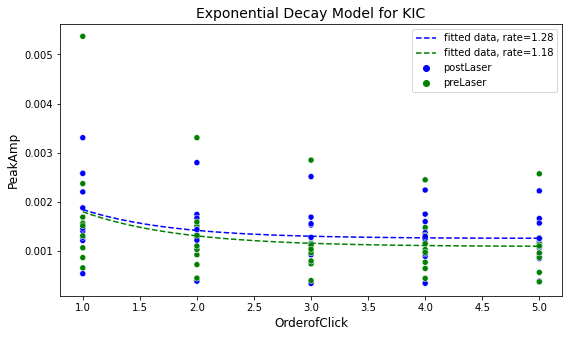

Model parameters for group KIT:
postLaser: intercept=0.001, rate=1.05, const=0.001
preLaser: intercept=0.001, rate=1.32, const=0.001


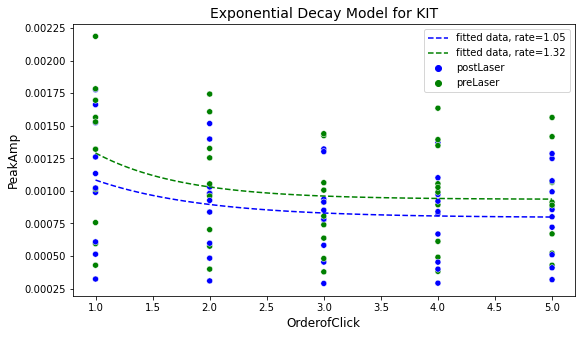

Model parameters for group KIV:
postLaser: intercept=0.002, rate=1.13, const=0.001
preLaser: intercept=0.002, rate=0.95, const=0.001


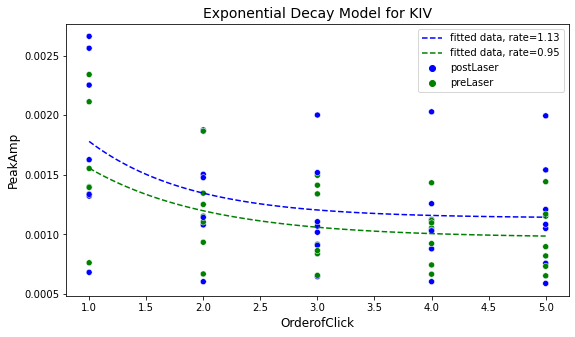

In [14]:
freq = 5
layer = "All"

if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

exp_decay_model = ExponentialDecay(n_clicks=freq)

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"Model parameters for group {group}:")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['PeakAmp']

        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.scatterplot(
        data=temp_data, x='OrderofClick', y='PeakAmp', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()

In [11]:
msrmnt = "preLaser"
group = "KIT"

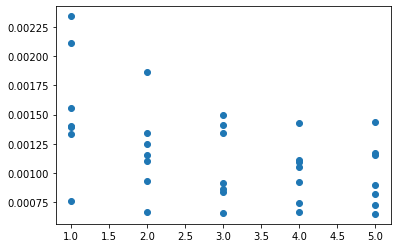

In [28]:
temp_data = model_data[model_data['Group'] == group]

xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
ydata = temp_data[temp_data['Measurement'] == msrmnt]['PeakAmp']
plt.plot(xdata, ydata, 'o')

In [18]:
ooc = temp_data['OrderofClick'].unique()[1]

In [46]:
ydata_boot = np.array([])

In [37]:

xdata = temp_data[cndtn]['OrderofClick']
ydata = temp_data[cndtn]['PeakAmp']
ydata

15480    0.001251
16250    0.001153
17020    0.001345
17790    0.001103
18560    0.001866
19330    0.000668
20100    0.000934
Name: PeakAmp, dtype: float64

In [45]:
ydata_boot = np.append(
    arr=ydata_boot, 
    values=np.random.choice(
        a=ydata, 
        size=len(ydata),
        replace=True))
ydata_boot

array([0.00134532, 0.00134532, 0.00066791, 0.00186585, 0.00066791,
       0.00115301, 0.00066791, 0.00093368, 0.00134532, 0.00110339,
       0.00093368, 0.00066791, 0.00125086, 0.00093368, 0.00115301,
       0.00093368, 0.00125086, 0.00115301, 0.00186585, 0.00134532,
       0.00110339, 0.00125086, 0.00110339, 0.00115301, 0.00066791,
       0.00066791, 0.00115301, 0.00066791, 0.00115301, 0.00134532,
       0.00093368, 0.00186585, 0.00186585, 0.00134532, 0.00115301])

In [7]:
freq = 5
layer = "All"
group = "KIC"
n_boot = 500
betas = {'preLaser': [], 'postLaser': []}

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]
temp_data = model_data[model_data['Group'] == group]

clicks = temp_data['OrderofClick'].unique()

exp_decay_model = ExponentialDecay(n_clicks=5)

for _ in tqdm(range(1000)):
    for msrmnt in ['preLaser', 'postLaser']:
        
        xdata_boot = np.array([])
        ydata_boot = np.array([])
        
        for ooc in clicks:
            
            cndtn = (temp_data['Measurement'] == msrmnt) & (temp_data['OrderofClick'] == ooc)
            xdata = temp_data[cndtn]['OrderofClick']
            ydata = temp_data[cndtn]['PeakAmp']
            
            xdata_boot = np.append(
                arr=xdata_boot,
                values=np.array([ooc]*len(ydata)))
            
            ydata_boot = np.append(
                arr=ydata_boot,
                values=np.random.choice(
                    a=ydata, 
                    size=len(ydata),
                    replace=True))
        
        exp_decay_model.fit(
            xdata=xdata_boot,
            ydata=ydata_boot)

        betas[msrmnt].append(exp_decay_model.get_params()[1])

100%|██████████| 1000/1000 [00:37<00:00, 26.47it/s]


In [8]:
pre = np.array(betas['preLaser'])
post = np.array(betas['postLaser'])

(array([589., 118.,  20.,  10.,  51., 190.,  20.,   1.,   0.,   1.]),
 array([5.35892539e-05, 2.00823092e+00, 4.01640825e+00, 6.02458558e+00,
        8.03276291e+00, 1.00409402e+01, 1.20491176e+01, 1.40572949e+01,
        1.60654722e+01, 1.80736496e+01, 2.00818269e+01]),
 <BarContainer object of 10 artists>)

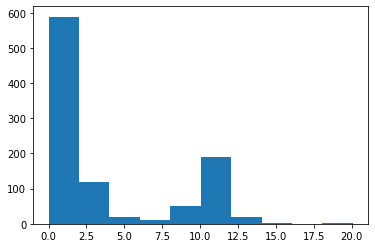

In [13]:
plt.hist(pre)

(array([478., 163.,  45.,  13.,   3.,   5.,  32., 116., 133.,  12.]),
 array([5.05849503e-05, 1.36546503e+00, 2.73087948e+00, 4.09629392e+00,
        5.46170837e+00, 6.82712282e+00, 8.19253726e+00, 9.55795171e+00,
        1.09233662e+01, 1.22887806e+01, 1.36541950e+01]),
 <BarContainer object of 10 artists>)

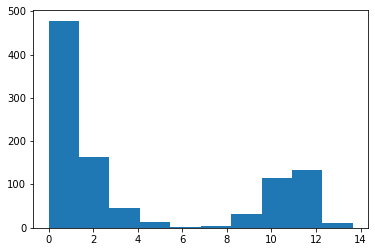

In [14]:
plt.hist(post)

In [16]:
plt.hist(pre/pos, bins=50)
plt.show()

NameError: name 'pos' is not defined

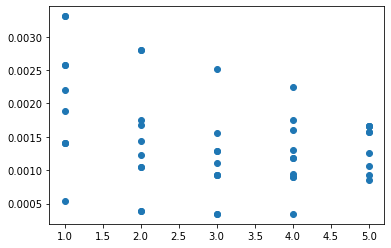

In [10]:
plt.plot(xdata_boot, ydata_boot, 'o')

In [11]:
exp_decay_model.get_params()

array([4.55923832e-03, 1.72458411e+00, 1.25593885e-03])

AttributeError: 'numpy.ndarray' object has no attribute 'name'

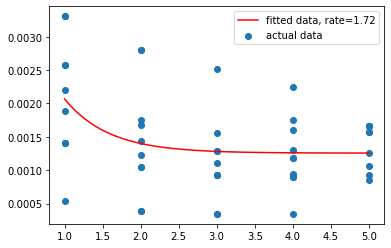

In [12]:
exp_decay_model.plot_fit(xdata=xdata_boot,
            ydata=ydata_boot)

In [94]:
ratios = np.array(betas['postLaser']) / np.array(betas['preLaser'])

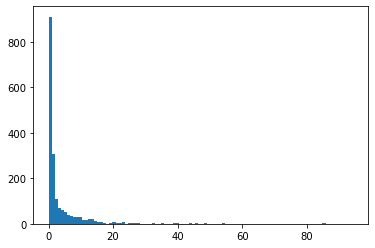

In [103]:
plt.hist(ratios[ratios < 100], bins=100)
plt.show()

In [98]:
ratios[ratios>=1].shape[0] / ratios.shape[0]

0.523

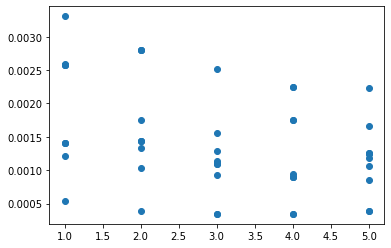

In [104]:
plt.plot(xdata_boot, ydata_boot, 'o')

In [106]:
exp_decay_model = ExponentialDecay(n_clicks=5)
exp_decay_model.fit(xdata=xdata_boot, ydata=ydata_boot)
exp_decay_model.get_params()

array([0.00174086, 0.57766916, 0.00102174])

AttributeError: 'numpy.ndarray' object has no attribute 'name'

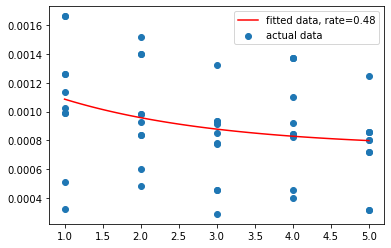

In [60]:
exp_decay_model.plot_fit(xdata=xdata_boot, ydata=ydata_boot)

In [54]:
xdata_boot

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [70]:
betas['prop'] = np.array(betas['postLaser']) / np.array(betas['preLaser'])

In [71]:
np.array(betas['preLaser']).min()

7.801152484181496e-05

In [75]:
betas['prop'].max()

127797.53164103844

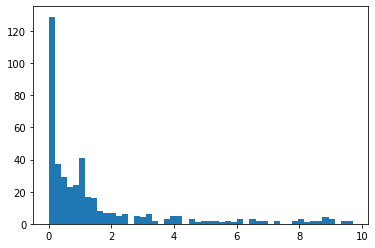

In [79]:
plt.hist(betas['prop'][betas['prop'] < 10], bins=50)
plt.show()

In [48]:



    
    exp_decay_model.fit(
        xdata=x_sample,
        ydata=y_sample)
    
    betas.append(exp_decay_model.get_params()[1])
    

 65%|██████▌   | 652/1000 [00:03<00:02, 138.04it/s]/home/ruslan/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 1000/1000 [00:05<00:00, 167.12it/s]


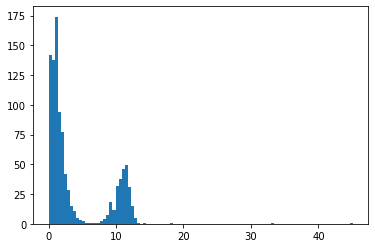

In [57]:
plt.hist(betas, bins=100)
plt.show()

## 10 Hz

Model parameters for group KIC:
postLaser: intercept=0.006, rate=1.88, const=0.001
preLaser: intercept=0.006, rate=1.89, const=0.001


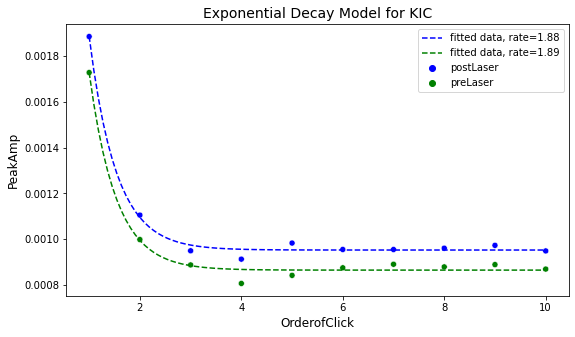

Model parameters for group KIT:
postLaser: intercept=0.002, rate=1.59, const=0.001
preLaser: intercept=0.004, rate=2.10, const=0.001


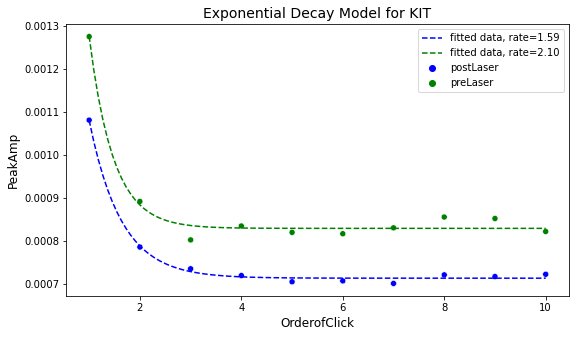

Model parameters for group KIV:
postLaser: intercept=0.003, rate=1.54, const=0.001
preLaser: intercept=0.003, rate=1.32, const=0.001


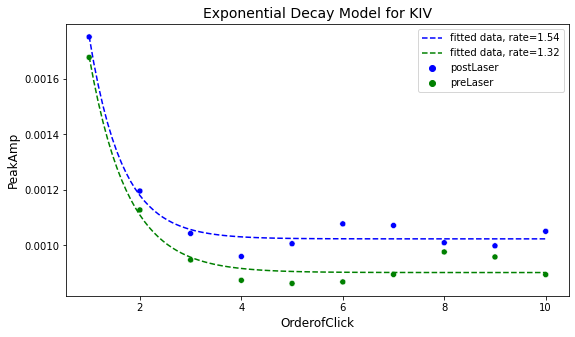

In [14]:
freq = 10
layer = "All"

if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

# model init
exp_decay_model = ExponentialDecay(n_clicks=freq)

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"Model parameters for group {group}:")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['PeakAmp']

        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params
        
        # new objects for plots
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.scatterplot(
        data=temp_data, x='OrderofClick', y='PeakAmp', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()
    
# ANCOVA

In [21]:
pprint.pprint(total_params)

{5: {'All': {'KIC': {'postLaser': array([2.10926784e-03, 1.27869673e+00, 1.25948638e-03]),
                     'preLaser': array([2.30281098e-03, 1.18020021e+00, 1.09478781e-03])},
             'KIT': {'postLaser': array([8.24878670e-04, 1.05072146e+00, 7.94832927e-04]),
                     'preLaser': array([1.33312181e-03, 1.32009219e+00, 9.35039863e-04])},
             'KIV': {'postLaser': array([0.00198102, 1.12540813, 0.00113688]),
                     'preLaser': array([0.00150775, 0.95092255, 0.00097282])}}},
 10: {'All': {'KIC': {'postLaser': array([6.12295823e-03, 1.88097670e+00, 9.52639362e-04]),
                      'preLaser': array([5.73647601e-03, 1.89376732e+00, 8.64909522e-04])},
              'KIT': {'postLaser': array([1.79761780e-03, 1.58870818e+00, 7.12905407e-04]),
                      'preLaser': array([3.65236237e-03, 2.10232711e+00, 8.28666400e-04])},
              'KIV': {'postLaser': array([3.39994913e-03, 1.53977141e+00, 1.02364892e-03]),
                

# RMS

## 5 Hz

Model parameters for group KIC:
postLaser: intercept=0.006, rate=3.38, const=0.001
preLaser: intercept=0.001, rate=1.53, const=0.001


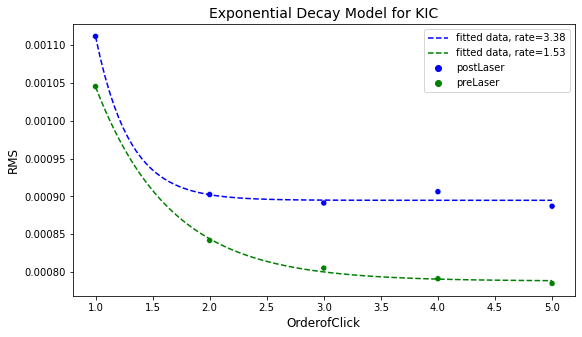

Model parameters for group KIT:
postLaser: intercept=0.000, rate=1.10, const=0.001
preLaser: intercept=0.001, rate=2.00, const=0.001


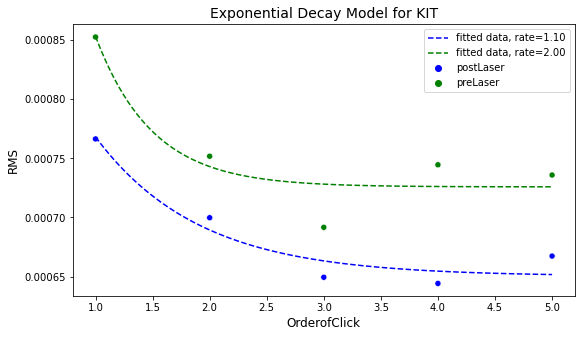

Model parameters for group KIV:
postLaser: intercept=0.002, rate=1.83, const=0.001
preLaser: intercept=0.001, rate=1.32, const=0.001


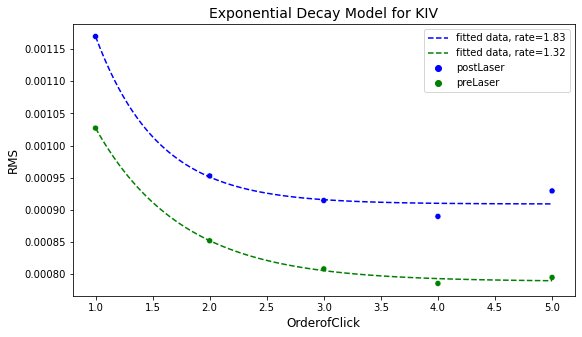

In [10]:
freq = 5
layer = "All"

if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

exp_decay_model = ExponentialDecay(n_clicks=freq)

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"Model parameters for group {group}:")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['RMS']

        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params.round(3)
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.scatterplot(
        data=temp_data, x='OrderofClick', y='RMS', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()

## 10 Hz

Model parameters for group KIC:
postLaser: intercept=0.002, rate=1.73, const=0.001
preLaser: intercept=0.002, rate=1.53, const=0.001


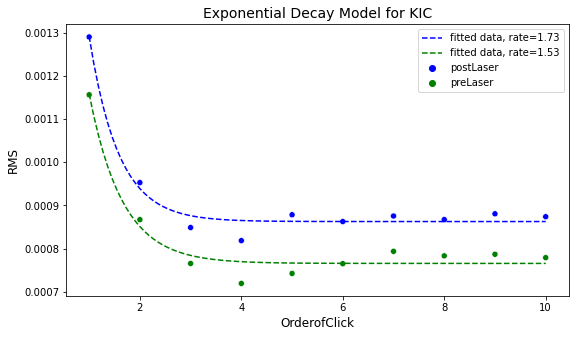

Model parameters for group KIT:
postLaser: intercept=0.000, rate=1.13, const=0.001
preLaser: intercept=0.001, rate=1.53, const=0.001


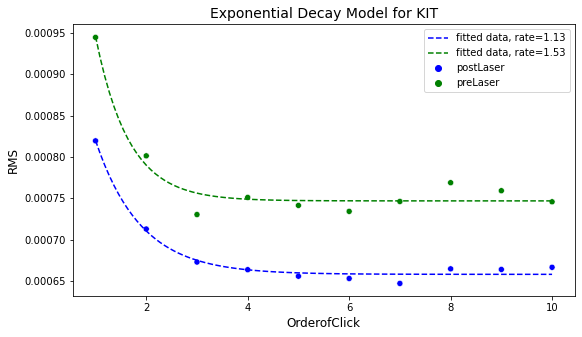

Model parameters for group KIV:
postLaser: intercept=0.002, rate=1.77, const=0.001
preLaser: intercept=0.001, rate=1.11, const=0.001


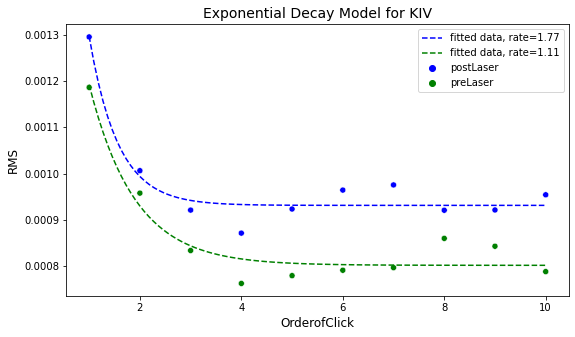

In [11]:
freq = 10
layer = "All"

if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

exp_decay_model = ExponentialDecay(n_clicks=freq)

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"Model parameters for group {group}:")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['RMS']

        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params.round(3)
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.scatterplot(
        data=temp_data, x='OrderofClick', y='RMS', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()

## Mess

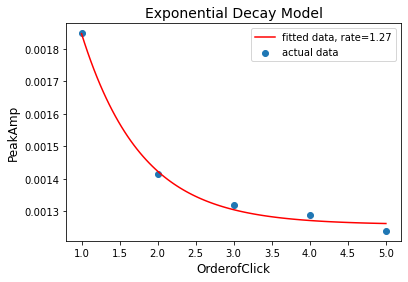

array([2.10035308e-03, 1.27238194e+00, 1.25823787e-03])

In [245]:
cndt = (model_data['Measurement'] == "postLaser") & (model_data['Group'] == "KIC")

exp_decay_model.fit(
    xdata=model_data[cndt]['OrderofClick'],
    ydata=model_data[cndt]['PeakAmp'])
exp_decay_model.predict()
exp_decay_model.plot_fit(
    xdata=model_data[cndt]['OrderofClick'],
    ydata=model_data[cndt]['PeakAmp'])
exp_decay_model.params

In [258]:
model_data[cndt]['OrderofClick']

2    1
3    2
4    3
5    4
6    5
Name: OrderofClick, dtype: int64

In [259]:
ypred

2    0.001847
3    0.001423
4    0.001304
5    0.001271
6    0.001262
Name: OrderofClick, dtype: float64

In [248]:
ypred = exp_decay_model.params[0]*np.exp(-exp_decay_model.params[1]*model_data[cndt]['OrderofClick']) + exp_decay_model.params[2]

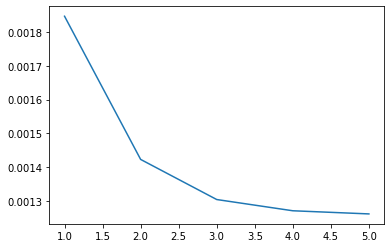

In [249]:
plt.plot(model_data[cndt]['OrderofClick'], ypred)

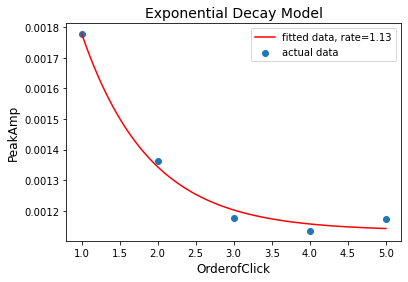

array([0.00199118, 1.12749792, 0.00113516])

In [162]:
exp_decay_model.fit(
    xdata=model_data[model_data['Measurement'] == 'postLazer']['OrderofClick'],
    ydata=model_data[model_data['Measurement'] == 'postLazer']['PeakAmp'])
exp_decay_model.predict()
exp_decay_model.plot_fit(
    xdata=model_data[model_data['Measurement'] == 'postLazer']['OrderofClick'],
    ydata=model_data[model_data['Measurement'] == 'postLazer']['PeakAmp'])
exp_decay_model.params

[0.00150862 0.95117669 0.00097266]


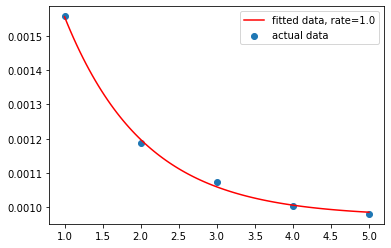

In [85]:
params, cv = curve_fit(
    f=exp_decay, 
    xdata=agg_data[agg_data['Measurement'] == 'preLazer']['OrderofClick'], 
    ydata=agg_data[agg_data['Measurement'] == 'preLazer']['PeakAmp'])
print(params)
x_temp = np.linspace(1, 5, 100)
plt.plot(
    x_temp, 
    exp_decay(
        x_temp, 
        *params), 
    'r-', label=f"fitted data, rate={params[1]:.1f}")
plt.scatter(
    agg_data[agg_data['Measurement'] == 'preLazer']['OrderofClick'], 
    agg_data[agg_data['Measurement'] == 'preLazer']['PeakAmp'], 
    label="actual data")
plt.legend()
plt.show()

[0.00199118 1.12749792 0.00113516]


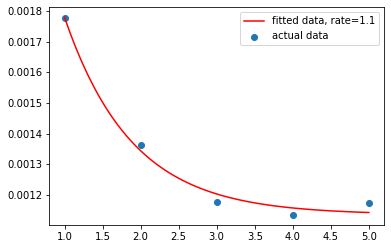

In [64]:
params, cv = curve_fit(
    f=exp_decay, 
    xdata=agg_data[agg_data['Measurement'] == 'postLazer']['OrderofClick'], 
    ydata=agg_data[agg_data['Measurement'] == 'postLazer']['PeakAmp'])
print(params)
x_temp = np.linspace(1, 5, 100)
plt.plot(
    x_temp, 
    exp_decay(
        x_temp, 
        *params), 
    'r-', label=f"fitted data, rate={params[1]:.1f}")
plt.scatter(
    agg_data[agg_data['Measurement'] == 'postLazer']['OrderofClick'], 
    agg_data[agg_data['Measurement'] == 'postLazer']['PeakAmp'], 
    label="actual data")
plt.legend()
plt.show()

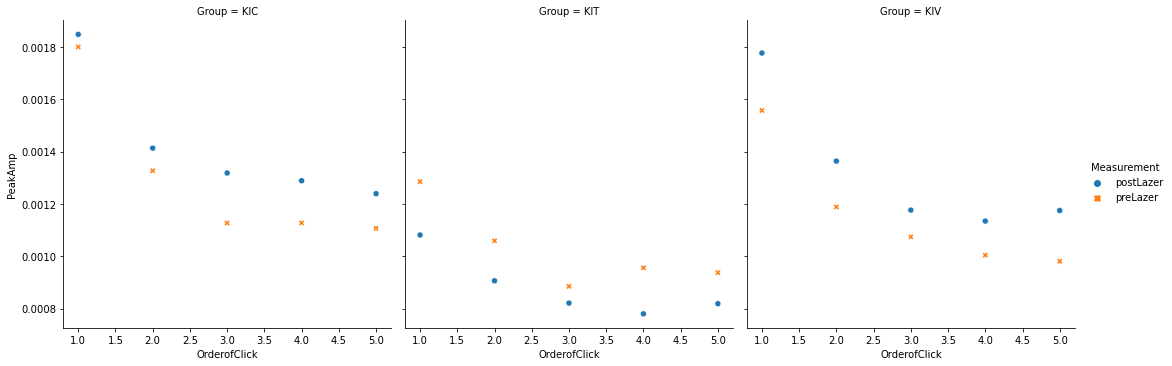

In [25]:
cndtn = (agg_data["Layer"] == "All") & (agg_data["ClickFreq"] == 5)
sns.relplot(
    data=agg_data[cndtn], x="OrderofClick", y="PeakAmp", col="Group",
    hue="Measurement", style="Measurement"
)